In [1]:
import cv2,glob,time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from moviepy.editor import VideoFileClip
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
#Load dataset here
#we use the Udacity provide dataset
vehicles = glob.glob('dataset/vehicles/vehicles/**/*.png')
unvehicles = glob.glob('dataset/non-vehicles/non-vehicles/**/*.png')

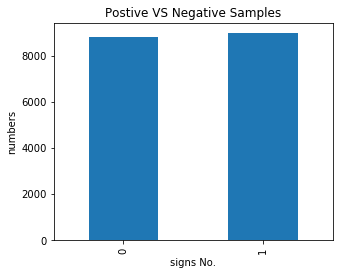

[8792, 8968]


In [3]:
#display the results
label = ['vehicles','unvehicles']
array = [len(vehicles),len(unvehicles)]
_nums_ = pd.Series.from_array(array)
plt.figure(figsize = (5,4))
fig = _nums_.plot(kind = 'bar')
fig.set_title('Postive VS Negative Samples')
fig.set_ylabel("numbers")
fig.set_xlabel("signs No.")
plt.show()
print(array)

In [4]:
#we can see the number of the Positive Samples is very close to the number of Negative samples,
#Visiulization the dataset for both Positive and Negative samples

In [5]:
#the size of each image(random choose 20 samples from whole dataset)
#here we find all 20 random sampled images are all 64*63*3 shapes
import random
for i in range(20):
    samples_idx = random.randint(0,len(vehicles))
    file_name = vehicles[samples_idx]
    #print(file_name)
    img = mpimg.imread(file_name)
    print(img.shape)

(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


In [6]:
#scan whole postive & negative dataset, is all images are all the same shapes?
#postive data: 8792;  negative data: 8968
#all data are 64*64*3, they have same shapes, we need not scale them to same h,w
counter = 0
shapes = (64,64,3)
for i in range(8792):
    file_name = vehicles[i]
    img = mpimg.imread(file_name)
    if(img.shape == shapes):
        counter += 1
print('The total number of postive data shape(64,64,3) is',counter)
counter = 0
for i in range(8968):
    file_name = unvehicles[i]
    img = mpimg.imread(file_name)
    if(img.shape == shapes):
        counter += 1
print('The total number of negative data shape(64,64,3) is',counter)

The total number of postive data shape(64,64,3) is 8792
The total number of negative data shape(64,64,3) is 8968


In [7]:
#random sample 45 images from vehicles/nonvehicles dataset, and visiulization them
def image_visiulization(is_vehicles = True):
    data = []
    if(is_vehicles):
        data = vehicles
    else:
        data = unvehicles
    plt.figure(figsize = (5,2), dpi = 160)
    for i in range(45):
        idx = random.randint(0,len(vehicles))
        ax = plt.subplot(3,15,i+1)
        ax.axis('off')
        file_name = data[idx]
        img = mpimg.imread(file_name)
        ax.imshow(img)
    plt.show()

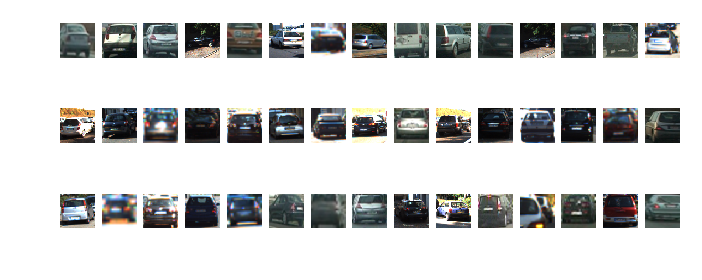

In [8]:
#vehicles dataset visiulization
image_visiulization(is_vehicles=True)

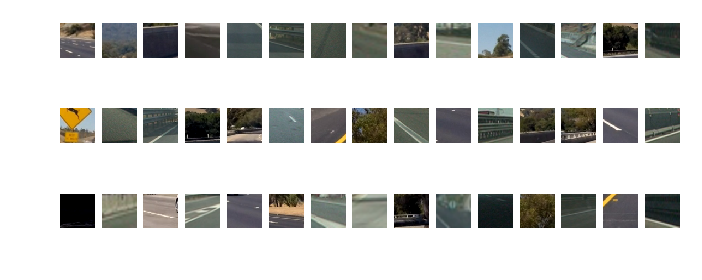

In [9]:
#nonvehicles dataset
image_visiulization(is_vehicles=False)

In [10]:
#Apply random brightness, contrast and saturation jitter in random order
#to our dataset, make the dataset more rubust

In [11]:
#This code moved from my CarND P2, the original code is copy from mxnet
def ColorJitterAug(img, brightness, contrast, saturation):
    """Apply random brightness, contrast and saturation jitter in random order"""
    coef = np.array([[[0.299, 0.587, 0.114]]])
    if brightness > 0:
        """Augumenter body"""
        alpha = 1.0 + random.uniform(-brightness, brightness) * 0.7
        img *= alpha
        img = np.clip(img, 0.,255.)

    if contrast > 0:
        """Augumenter body"""
        alpha = 1.0 + random.uniform(-contrast, contrast) * 0.7
        gray = img*coef
        gray = (3.0*(1.0-alpha)/gray.size)*np.sum(gray)
        img *= alpha
        img += gray
        img = np.clip(img, 0.,255.)

    if saturation > 0:
        """Augumenter body"""
        alpha = 1.0 + random.uniform(-saturation, saturation) * 0.7
        gray = img*coef
        gray = np.sum(gray, axis=2, keepdims=True)
        gray *= (1.0-alpha)
        img *= alpha
        img += gray
        img = np.clip(img, 0.,255.)
    return img

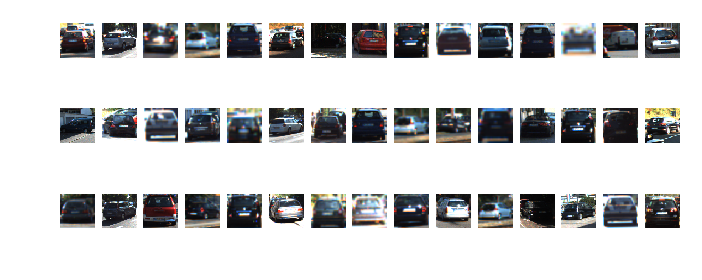

In [12]:
#apply the ColorJitterAug function to first 45 data, to see the different between original and new one
#we will apply this function later, before we start feature extract.
plt.figure(figsize = (5,2), dpi = 160)
for i in range(45):
    ax = plt.subplot(3,15,i+1)
    ax.axis('off')
    file_name = vehicles[i]
    img = mpimg.imread(file_name)
    ax.imshow(img)
plt.show()

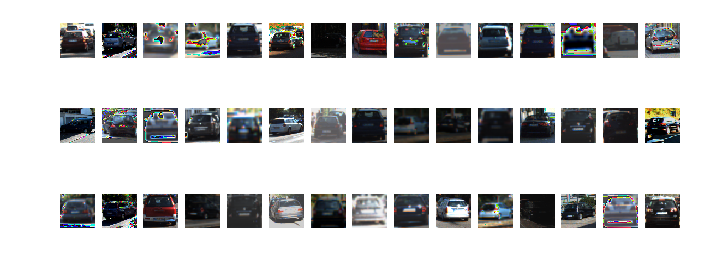

In [13]:
plt.figure(figsize = (5,2), dpi = 160)
for i in range(45):
    ax = plt.subplot(3,15,i+1)
    ax.axis('off')
    file_name = vehicles[i]
    img = mpimg.imread(file_name)
    is_brightness = random.randint(0,1)
    is_contrast = random.randint(0,1)
    is_saturation = random.randint(0,1)
    generate_image = ColorJitterAug(img, is_brightness, is_contrast, is_saturation)
    ax.imshow(generate_image)
plt.show()

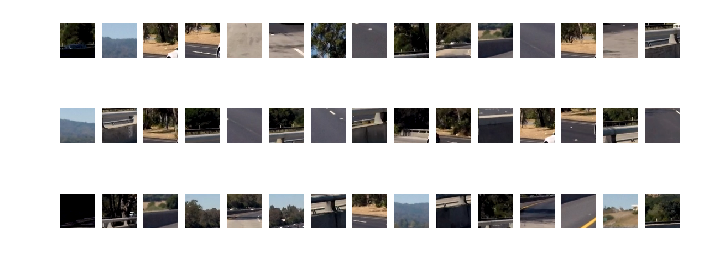

In [14]:
plt.figure(figsize = (5,2), dpi = 160)
for i in range(45):
    ax = plt.subplot(3,15,i+1)
    ax.axis('off')
    file_name = unvehicles[i]
    img = mpimg.imread(file_name)
    ax.imshow(img)
plt.show()

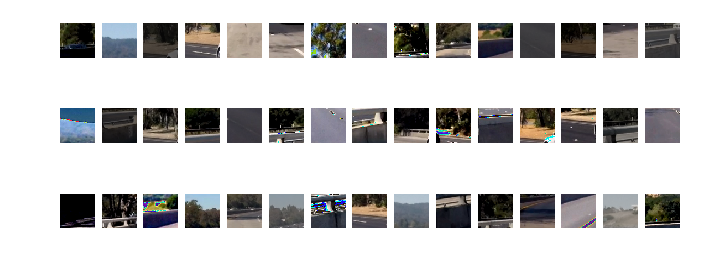

In [15]:
plt.figure(figsize = (5,2), dpi = 160)
for i in range(45):
    ax = plt.subplot(3,15,i+1)
    ax.axis('off')
    file_name = unvehicles[i]
    img = mpimg.imread(file_name)
    is_brightness = random.randint(0,1)
    is_contrast = random.randint(0,1)
    is_saturation = random.randint(0,1)
    generate_image = ColorJitterAug(img, is_brightness, is_contrast, is_saturation)
    ax.imshow(generate_image)
plt.show()

In [16]:
#we can see, after we applied the ColorJitterAug function to our data can generate many low-quality data,
#if we applied those methods to our whole dataset, and using them to train our classifier may can make
#our classifier more rubust

In [17]:
#Now, apllied ColorJitterAug to our dataset, before we using it, we should read all dataset from lists
#the dataset is too small, so we just read them to our ram, need not create imdb to store the data
pos_data = []
for i in range(len(vehicles)):
    file_name = vehicles[i]
    img = mpimg.imread(file_name)
    pos_data.append(img)
print(np.array(pos_data).shape)
neg_data = []
for i in range(len(unvehicles)):
    file_name = unvehicles[i]
    img = mpimg.imread(file_name)
    neg_data.append(img)
print(np.array(neg_data).shape)

(8792, 64, 64, 3)
(8968, 64, 64, 3)


In [18]:
#Defined Hog features here

In [19]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

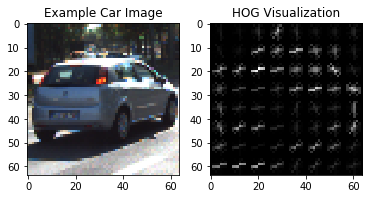

In [20]:
# Read in the image
image = pos_data[1]
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

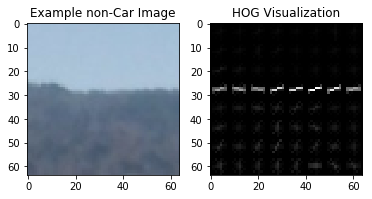

In [21]:
# Read in the image
image = neg_data[1]
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example non-Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [22]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [76]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                    hist_bins=32, hist_range=(0, 256),
                    orient=9, pix_per_cell=8, 
                    cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    #for file in imgs:
    print(len(imgs))
    for i in range(len(imgs)):
        # Read in each one by one
        #image = mpimg.imread(file)
        image = imgs[i]
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Apply bin_spatial() to get spatial color features
        #spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((hist_features,hog_features)))
        #features.append(hog_features)
    # Return list of feature vectors
    return features

In [77]:
#apply ColorJitterAug function to pos_data/neg_data
#for i in range(len(vehicles)):
#    img = np.array(pos_data[i])
#    is_brightness = random.randint(0,1)
#    is_contrast = random.randint(0,1)
#    is_saturation = random.randint(0,1)
#    generate_image = ColorJitterAug(img, is_brightness, is_contrast, is_saturation)
#    pos_data.append(generate_image)
#print(np.array(pos_data).shape)

#for i in range(len(unvehicles)):
#    img = np.array(neg_data[i])
#    is_brightness = random.randint(0,1)
#    is_contrast = random.randint(0,1)
#    is_saturation = random.randint(0,1)
#    generate_image = ColorJitterAug(img, is_brightness, is_contrast, is_saturation)
#    neg_data.append(generate_image)
#print(np.array(neg_data).shape)

In [78]:
# Feature extraction parameters
colorspace = 'YUV' 
orient = 7
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' 
t = time.time()
vehicle_features = extract_features(pos_data, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
unvehicle_features = extract_features(neg_data, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
print(round(time.time()-t, 2), 'Seconds to extract the HOG features')

8792
8968
34.07 Seconds to extract the HOG features


In [79]:
#train the classifier

In [80]:
#YUV ALL channel extract here
from sklearn.preprocessing import StandardScaler
pos_label = np.ones(len(pos_data))
neg_label = np.zeros(len(neg_data))
print(pos_label.shape,neg_label.shape)
y = np.hstack((pos_label,neg_label))
print(y.shape)
X = np.vstack((vehicle_features, unvehicle_features)).astype(np.float64) 
#data normalize
x_scale_yuv = StandardScaler().fit(X)
x_data = x_scale_yuv.transform(X)
print(x_data.shape)
#train/test split
X_train, X_test, y_train, y_test = train_test_split(x_data, y, test_size=0.2, random_state=12)

(8792,) (8968,)
(17760,)
(17760, 852)


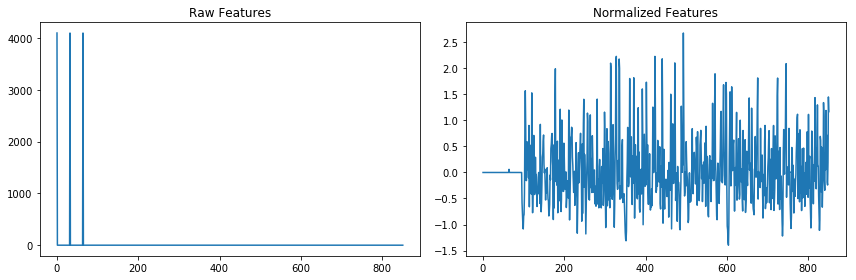

In [81]:
#example before normalized & after normalized
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(X[1])
plt.title('Raw Features')
plt.subplot(122)
plt.plot(x_data[1])
plt.title('Normalized Features')
fig.tight_layout()

In [82]:
#Train the SVM classifier
#first train simple RBG ALL chennel svm classifier
svc = LinearSVC()
t = time.time()
svc.fit(X_train, y_train)
print('SVC training cost',(time.time()-t))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

SVC training cost 2.1134204864501953
Test Accuracy of SVC =  0.9761


In [83]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [84]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins=32, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg)

            # Scale features and make a prediction
            test_features = x_scale_yuv.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            #hog_features = x_scale_yuv.transform(hog_features)
            #test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [85]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

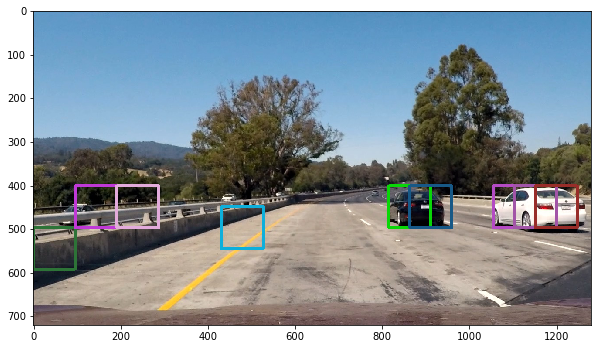

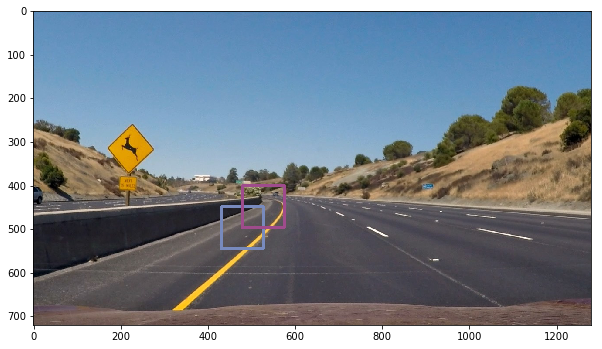

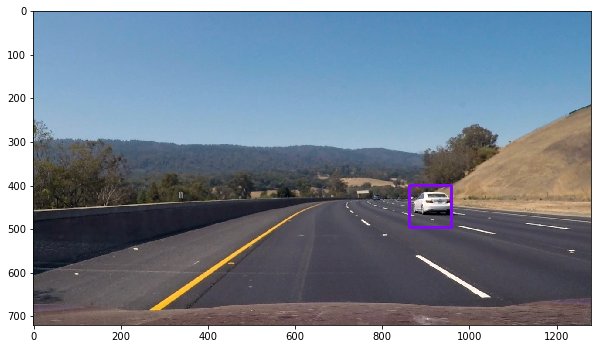

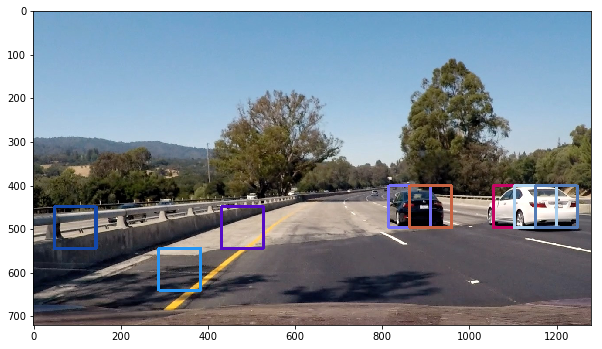

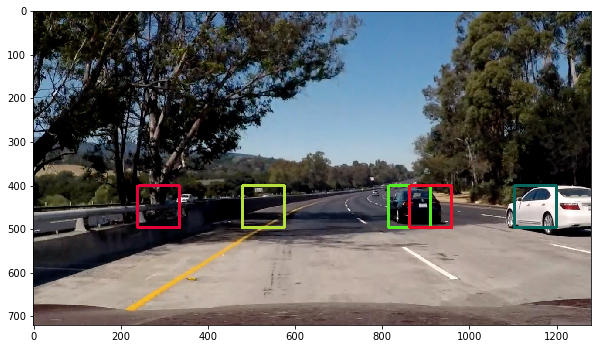

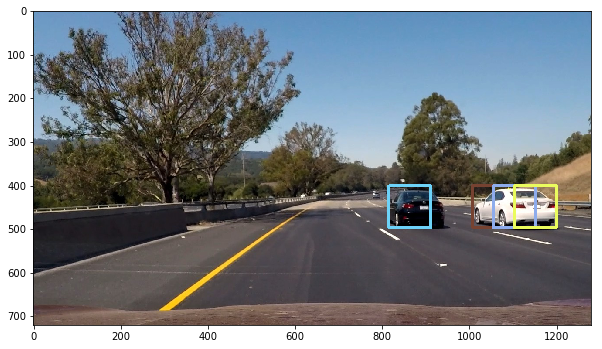

In [86]:

for i in range(6):
    test_img = mpimg.imread('./test_images/test{}.jpg'.format(i+1))
    ystart = 400
    ystop = 656
    scale = 1.5
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 7
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, show_all_rectangles=False)
    test_img_rects = draw_boxes(test_img, rectangles)
    plt.figure(figsize=(10,10))
    plt.imshow(test_img_rects)

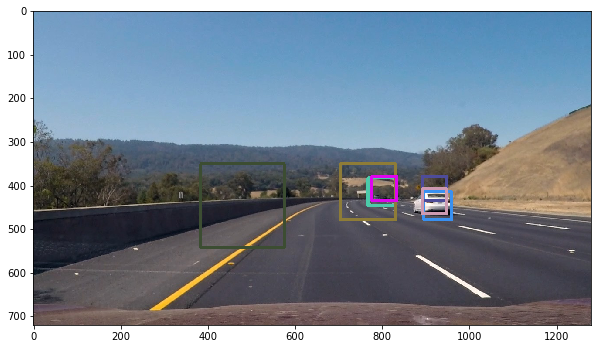

In [87]:
test_img = mpimg.imread('./test_images/test3.jpg')
rectangles = []
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 7
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
ystart = 350
ystop = 656
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, show_all_rectangles=False))
ystart = 350
ystop = 656
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, show_all_rectangles=False))
ystart = 350
ystop = 656
scale = 3.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, show_all_rectangles=False))
ystart = 350
ystop = 500
scale = 0.9
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, show_all_rectangles=False))
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

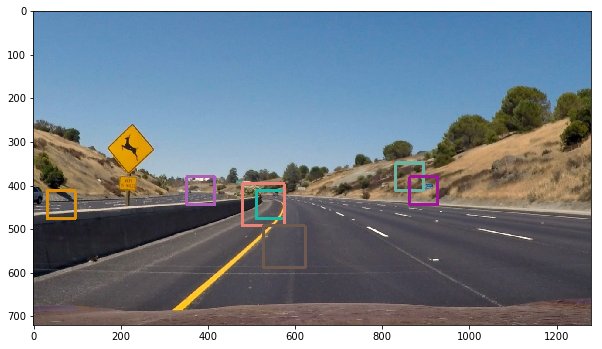

In [88]:
#for i in range(6):
test_img = mpimg.imread('./test_images/test2.jpg')
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 7
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
rectangles = []
ystart = 380
ystop = 444
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, show_all_rectangles=False))
ystart = 348
ystop = 476
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, show_all_rectangles=False))
ystart = 348
ystop = 538
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, show_all_rectangles=False))
ystart = 348
ystop = 666
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, show_all_rectangles=False))
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

In [89]:
#Heatmap

In [90]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [91]:
#Threshould the results, and reduce the detected windows
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [92]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        if((np.max(nonzerox)-np.min(nonzerox)) / (np.max(nonzeroy) -np.min(nonzeroy)))>0.7:
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            rects.append(bbox)
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

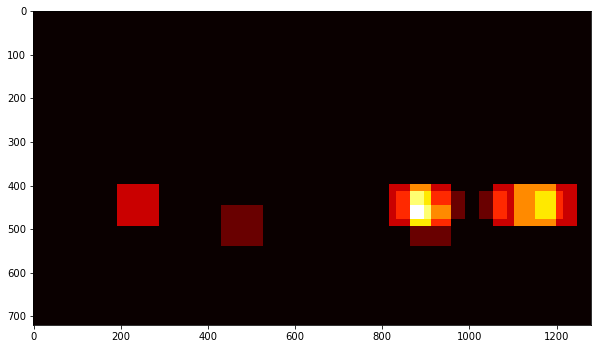

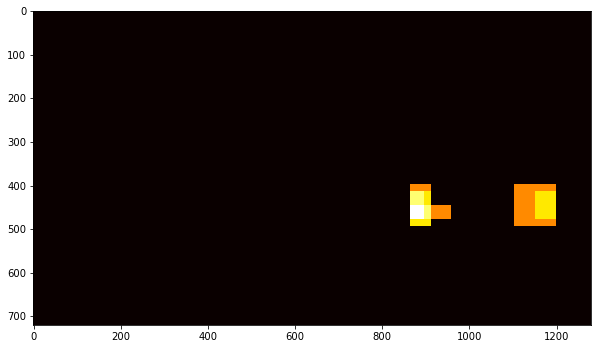

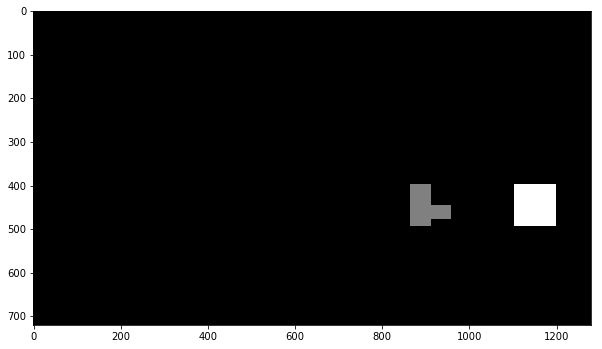

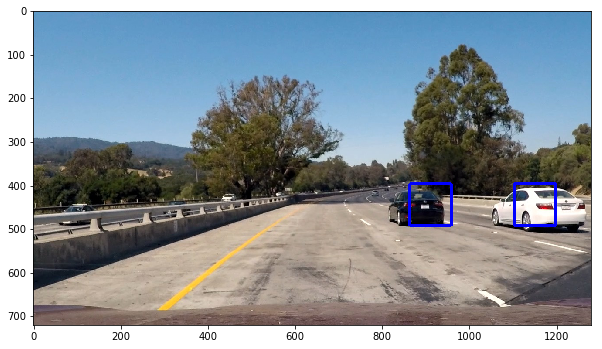

In [93]:
test_img = mpimg.imread('./test_images/test1.jpg')
rectangles = []
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 7
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
rectangles = []
ystart = 380
ystop = 444
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, show_all_rectangles=False))
ystart = 348
ystop = 476
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, show_all_rectangles=False))
ystart = 348
ystop = 538
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, show_all_rectangles=False))
ystart = 348
ystop = 666
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, show_all_rectangles=False))
rectangles = [item for sublist in rectangles for item in sublist] 
#test_img_rects = draw_boxes(test_img, rectangles)
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat_add = add_heat(heat,rectangles)
#heat = add_heat(heat,all_windows)
plt.figure(figsize=(10,10))
plt.imshow(heat_add,cmap='hot')    
# Apply threshold to help remove false positives
heat_threshold = apply_threshold(heat_add,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat_threshold, 0, 255)
plt.figure(figsize=(10,10))
plt.imshow(heatmap, cmap='hot')
# Find final boxes from heatmap using label function
labels = label(heatmap)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [94]:
def pipeline_unstable(img):
    rectangles = []
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 7
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist] 
    #add_rects(rectangles)
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 2)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

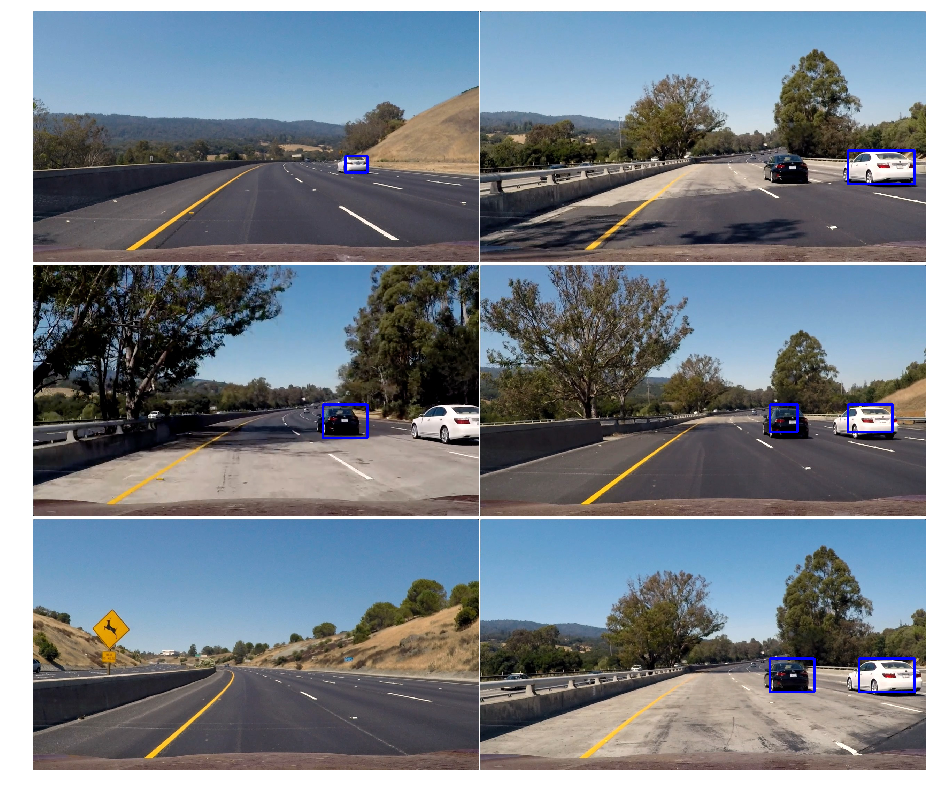

In [95]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(pipeline_unstable(mpimg.imread(im)))
    axs[i].axis('off')

In [114]:
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 10:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-10:]

In [128]:
def pipeline(img):
    rectangles = []
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 7
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 464#480
    scale = 1.5#1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    #ystart = 400
    #ystop = 496
    #scale = 1.5
    #rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
    #                       orient, pix_per_cell, cell_per_block, None, None))
    
    ystart = 432
    ystop = 528
    scale = 2.0#1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist] 

    if len(rectangles) > 0:
        det.add_rects(rectangles)
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    #heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 10)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [129]:
det = Vehicle_Detect()
video_output = "output_images/test_video_output.mp4"
clip1 = VideoFileClip("test_video.mp4")
clip1_output = clip1.fl_image(pipeline)
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/test_video_output.mp4
[MoviePy] Writing video output_images/test_video_output.mp4


 97%|█████████▋| 38/39 [00:05<00:00,  6.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video_output.mp4 

CPU times: user 13 s, sys: 60 ms, total: 13 s
Wall time: 6.54 s


In [130]:
det = Vehicle_Detect()
video_output = "output_images/project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip1_output = clip1.fl_image(pipeline)
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [03:16<00:00,  6.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 7min 20s, sys: 1.79 s, total: 7min 22s
Wall time: 3min 16s
